Imports necesarios

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, accuracy_score, top_k_accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay

In [41]:
df = pd.read_csv("https://raw.githubusercontent.com/Manueehh/TFG-Football-Prediction/main/data/processed/laliga_features.csv")
print(f"Dataset cargado: {df.shape[0]} partidos, {df.shape[1]} columnas")
df

Dataset cargado: 7600 partidos, 74 columnas


,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR,B365H,B365D,B365A,elo_home,elo_away,elo_diff,home_avg_goals_scored_7,away_avg_goals_scored_7,home_avg_goals_conceded_7,away_avg_goals_conceded_7,goal_diff_form_home,goal_diff_form_away,home_avg_shots_7,away_avg_shots_7,home_avg_shots_on_target_7,away_avg_shots_on_target_7,home_avg_corners_7,away_avg_corners_7,home_avg_fouls_7,away_avg_fouls_7,home_avg_yellows_7,away_avg_yellows_7,home_avg_reds_7,away_avg_reds_7,attack_strength_home,attack_strength_away,defense_strength_home,defense_strength_away,discipline_index_home,discipline_index_away,derby,result_string,result_abstract,B365H_prob,B365D_prob,B365A_prob,prob_diff_home_away,prob_fav_margin,Home_Lineup_List,Away_Lineup_List,Season,home_team_norm,away_team_norm,home_team_value,away_team_value,team_value_diff,team_value_ratio,shots_on_target_ratio_home,shots_on_target_ratio_away,attack_vs_defense_home,total_avg_goals,attack_vs_defense_away
0,SP1,2005-08-27,Alavés,Barcelona,0,0,D,0,0,D,5,17,0,10,17,19,3,7,0,1,0,0,7.00,3.75,1.50,1500.000000,1500.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0-0,0-0,0.132743,0.247788,0.619469,-0.486726,0.486726,"['Roberto Bonano', 'Edu Alonso', 'Martín Astud...","['Víctor Valdés', 'Carles Puyol', 'Rafael Márq...",2005_06,alaves,barcelona,11900000.0,242250000.0,-230350000.0,0.049123,0.000000,0.000000,0.000000,0.000000,0.000000
1,SP1,2005-08-27,Athletic,R. Sociedad,3,0,H,0,0,D,10,9,6,2,13,19,3,4,0,1,0,0,2.00,3.25,3.25,1500.000000,1500.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1,3-0,M-0,0.448276,0.275862,0.275862,0.172414,0.172414,"['Daniel Aranzubia', 'Casas', 'Luis Prieto', '...","['Asier Riesgo', 'Labaka', 'Javi Garrido', 'Ló...",2005_06,athletic,r sociedad,28350000.0,22425000.0,5925000.0,1.264214,0.000000,0.000000,0.000000,0.000000,0.000000
2,SP1,2005-08-27,Valencia,Real Betis,1,0,H,0,0,D,9,14,2,3,18,14,8,5,2,3,0,0,2.00,3.25,3.25,1500.000000,1500.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,1-0,1-0,0.448276,0.275862,0.275862,0.172414,0.172414,"['Santiago Cañizares', 'Roberto Ayala', 'Fábio...","['Doblas', 'Juanito', 'Nano', 'Óscar López', '...",2005_06,valencia,real betis,113029999.0,47850000.0,65179999.0,2.362173,0.000000,0.000000,0.000000,0.000000,0.000000
3,SP1,2005-08-28,Atlético,Real Zaragoza,0,0,D,0,0,D,16,9,5,2,16,22,8,4,2,7,0,0,1.72,3.40,4.00,1500.000000,1500.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0-0,0-0,0.516560,0.261319,0.222121,0.294439,0.294439,"['Leonardo Franco', 'Antonio López', 'Pablo Ib...","['César', 'Gabriel Milito', 'Delio Toledo', 'Á...",2005_06,atletico,real zaragoza,106000000.0,37450000.0,68550000.0,2.830441,0.000000,0.000000,0.000000,0.000000,0.000000
4,SP1,2005-08-28,Cádiz,Real Madrid,1,2,A,0,1,A,15,17,5,6,19,25,8,8,2,2,0,0,7.50,4.00,1.44,1500.000000,1500.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,1-2,1-2,0.123711,0.231959,0.644330,-0.520619,0.520619,"['Armando', 'Abraham Paz', 'De Quintana', 'Rau...","['Iker Casillas', 'Roberto Carlos', 'Míchel Sa...",2005_06,cadiz,real madrid,7750000.0,151500

In [42]:
# Eliminamos las primeras 7 jornadas (70 partidos) por el inicio de las medias a 0, que se calculan con los 7 partido
# Preguntar que es mejor, si eliminarlas directamente, o hacer la media o mediana de esos valores de jornadas futuras (podria incurrir en data leakage)
df_clean = df[df["home_avg_goals_scored_7"] != 0].copy()
print(f"Partidos eliminados por cold-start: {len(df) - len(df_clean)}")
print(f"Dataset limpio: {df_clean.shape[0]} partidos")

Partidos eliminados por cold-start: 280
Dataset limpio: 7320 partidos


In [43]:
# TEMPORAL, poner los equipos con valor a 0 con la mediana, cuando estén todas las alineaciones no será más necesario esto
for col in ["home_team_value", "away_team_value"]:
    df_clean[col] = df_clean.groupby("Season")[col].transform(
        lambda x: x.replace(0, np.nan).fillna(x.median())
    )

Seleccion de features




In [32]:
feature_selection = [
    # ELO
    "elo_home", "elo_away", "elo_diff",

    # Forma ofensiva/defensiva (rolling 7 partidos)
    "home_avg_goals_scored_7", "away_avg_goals_scored_7",
    "home_avg_goals_conceded_7", "away_avg_goals_conceded_7",
    "goal_diff_form_home", "goal_diff_form_away",
    "total_avg_goals",

    # Disparos
    "home_avg_shots_7", "away_avg_shots_7",
    "home_avg_shots_on_target_7", "away_avg_shots_on_target_7",
    "shots_on_target_ratio_home", "shots_on_target_ratio_away",

    # Corners y disciplina
    "home_avg_corners_7", "away_avg_corners_7",
    "home_avg_fouls_7", "away_avg_fouls_7",
    "home_avg_yellows_7", "away_avg_yellows_7",
    "home_avg_reds_7", "away_avg_reds_7",

    # Índices de fuerza
    "attack_strength_home", "attack_strength_away",
    "defense_strength_home", "defense_strength_away",
    "discipline_index_home", "discipline_index_away",
    "attack_vs_defense_home", "attack_vs_defense_away",

    # Valor de mercado
    "home_team_value", "away_team_value",
    "team_value_diff", "team_value_ratio",

    # Cuotas de apuestas
    "B365H_prob", "B365D_prob", "B365A_prob",
    "prob_diff_home_away", "prob_fav_margin",

    # Contexto
    "derby",
]

print(f"Total features: {len(feature_selection)}")

Total features: 42


Cross-validation con TimeSplit

In [33]:
test_seasons = ["2023_24", "2024_25"]

train = df_clean[~df_clean["Season"].isin(test_seasons)].copy()
test = df_clean[df_clean["Season"].isin(test_seasons)].copy()

X_train = train[feature_selection]
y_train = train["result_abstract"]

X_test = test[feature_selection]
y_test = test["result_abstract"]

print(f"Train: {X_train.shape[0]} partidos ({train['Season'].nunique()} temporadas)")
print(f"Test: {X_test.shape[0]} partidos ({test['Season'].nunique()} temporadas)")
print(f"Distribución de clases (train):")
print(y_train.value_counts().sort_index())


Train: 6560 partidos (18 temporadas)
Test: 760 partidos (2 temporadas)
Distribución de clases (train):
result_abstract
0-0    501
0-1    480
0-2    317
0-M    200
1-0    731
1-1    757
1-2    420
1-M    219
2-0    512
2-1    594
2-2    297
2-M    177
M-0    508
M-1    475
M-2    244
M-M    128
Name: count, dtype: int64


In [12]:
# TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=8)
'''
RandomizedSearch, ya ejecutado, mejores hiperparametros encontrados: n_estimators = 200, min_samples_split = 20, min_samples_leaf = 30, max_features = 0.3, max_depth = 6
param_dist = {
    "n_estimators":      [200, 400, 600, 800, 1000],
    "max_depth":         [6, 8, 10, 12, None],
    "min_samples_leaf":  [5, 10, 20, 30],
    "min_samples_split": [10, 20, 40],
    "max_features":      ["sqrt", "log2", 0.3, 0.5],
}

rf_base = RandomForestClassifier(random_state=42, n_jobs=-1)

search = RandomizedSearchCV(
    estimator=rf_base,
    param_distributions=param_dist,
    n_iter=40,
    scoring="accuracy",
    cv=tscv,
    random_state=42,
    n_jobs=-1,
    verbose=1,
    refit=True,
)

search.fit(X_train, y_train)
'''
param_grid_fino = {
    'n_estimators' : [150,200,300],
    'max_depth' : [5,6,7],
    'min_samples_leaf' : [25,30,35],
    'min_samples_split' : [15,20,25],
    'max_features' : [0.2,0.3,0.4],
}

grid_search = GridSearchCV(
    estimator = RandomForestClassifier(random_state=42, n_jobs=-1),
    param_grid = param_grid_fino,
    scoring = "accuracy",
    cv = tscv,
    n_jobs = -1,
    verbose = 1,
    refit = True,
)
grid_search.fit(X_train, y_train)


print("Mejores hiperparámetros encontrados")
for k, v in grid_search.best_params_.items():
    print(f"  {k}: {v}")
print(f"Mejor F1-macro en CV: {grid_search.best_score_:.4f}")


Fitting 8 folds for each of 243 candidates, totalling 1944 fits
Mejores hiperparámetros encontrados
  max_depth: 5
  max_features: 0.3
  min_samples_leaf: 35
  min_samples_split: 15
  n_estimators: 150
Mejor F1-macro en CV: 0.1410


In [47]:
clf = grid_search.best_estimator_
# El best_estimator_ ya está entrenado con todos los datos de train (refit=True)
print("Modelo final listo (entrenado sobre todo el conjunto de train).")
print(f"Parámetros: {clf.get_params()}")

Modelo final listo (entrenado sobre todo el conjunto de train).
Parámetros: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 5, 'max_features': 0.3, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 35, 'min_samples_split': 15, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 150, 'n_jobs': -1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


In [48]:
feat_imp = pd.DataFrame({
    "Feature":    feature_selection,
    "Importance": clf.feature_importances_,
}).sort_values("Importance", ascending=False).reset_index(drop=True)

plt.figure(figsize=(10, 10))
sns.barplot(data=feat_imp, x="Importance", y="Feature", palette="Blues_r")
plt.title("Importancia de features — Random Forest", fontsize=14)
plt.tight_layout()
plt.savefig("feature_importance.png", dpi=150)
plt.show()

print("Top 10 features:")
print(feat_imp.head(10).to_string(index=False))

ValueError: All arrays must be of the same length

In [18]:
y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)

acc = accuracy_score(y_test, y_pred)
top3_acc = top_k_accuracy_score(y_test, y_pred_proba, k=3, labels=clf.classes_)
top5_acc = top_k_accuracy_score(y_test, y_pred_proba, k=5, labels=clf.classes_)

print(f"Accuracy Top-1: {acc:.4f}  ({acc*100:.1f}%)")
print(f"Accuracy Top-3: {top3_acc:.4f}  ({top3_acc*100:.1f}%)")
print(f"Accuracy Top-5: {top5_acc:.4f}  ({top5_acc*100:.1f}%)")
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy Top-1: 0.1526  (15.3%)
Accuracy Top-3: 0.4211  (42.1%)
Accuracy Top-5: 0.6066  (60.7%)
              precision    recall  f1-score   support

         0-0       0.00      0.00      0.00        52
         0-1       0.12      0.27      0.17        60
         0-2       0.00      0.00      0.00        34
         0-M       0.14      0.04      0.06        27
         1-0       0.17      0.32      0.22       101
         1-1       0.15      0.32      0.21       108
         1-2       0.00      0.00      0.00        59
         1-M       0.00      0.00      0.00        17
         2-0       0.25      0.02      0.04        45
         2-1       0.13      0.19      0.15        57
         2-2       0.00      0.00      0.00        36
         2-M       0.00      0.00      0.00        21
         M-0       0.18      0.43      0.25        47
         M-1       0.00      0.00      0.00        39
         M-2       0.00      0.00      0.00        36
         M-M       0.00      0.00      

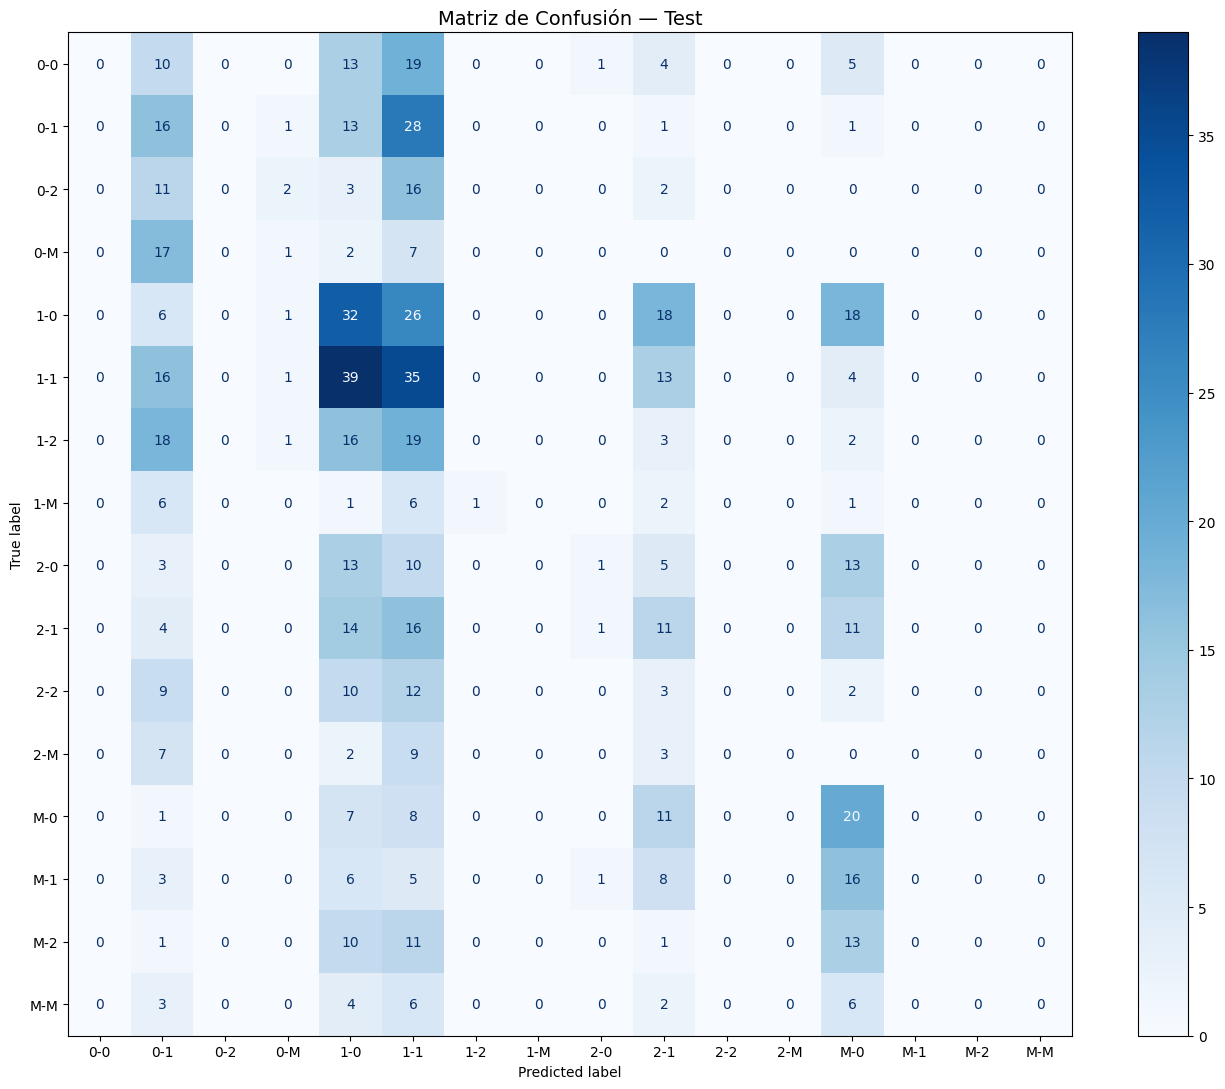

In [19]:
# ── Matriz de confusión
fig, ax = plt.subplots(figsize=(14, 11))
cm = confusion_matrix(y_test, y_pred, labels=sorted(clf.classes_))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=sorted(clf.classes_))
disp.plot(cmap=plt.cm.Blues, ax=ax, colorbar=True)
ax.set_title("Matriz de Confusión — Test", fontsize=14)
plt.tight_layout()
plt.savefig("confusion_matrix.png", dpi=150)
plt.show()